In [ ]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# K-means clustering libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option("display.max_rows", None,"display.max_columns", None)

warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

In [ ]:
# Importing dataset
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv('data.csv',sep=",", encoding="ISO-8859-1",header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
# basics of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
round(100*(df.isnull().sum())/len(df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

STEP 2 : Data preprocessing


In [ ]:
# Dropping records with missing Customer ID
# As customer segmentation would not be possible without Customer ID, so records with missing customer ID have been dropped.
df.dropna(inplace=True)
round(100*(df.isnull().sum())/len(df), 2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [ ]:
df.shape

(406829, 8)

In [ ]:
# Formatting 'CustomerID' and 'InvoiveDate'
df['CustomerID'] = df['CustomerID'].astype('int')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],infer_datetime_format=True)

In [ ]:
# Generating 'Amount' column using 'Quantity' & 'UnitPrice'
df['Amount'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


STEP 3: Data preparation for modeling


In [ ]:
# Calculating RFM metrics
# Calculating Monetary attribute; Monetary - Total or average amount spent by the customer.
cus_data = df.groupby('CustomerID')[['Amount']].sum() # Total amount spent
cus_data.rename(columns={'Amount':'Monetary'},inplace=True)
cus_data.head()

,Monetary
CustomerID,
12346,0.00
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


In [ ]:
# Calculating frequency attribute; Frequency - Total number of transactions made by customer or average time between transactions.
cus_data['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].count()
cus_data.head()

,Monetary,Frequency
CustomerID,,
12346,0.00,2
12347,4310.00,182
12348,1797.24,31
12349,1757.55,73
12350,334.40,17


In [ ]:
#Recency - Time since last order or engaged with product
max_date = max(df['InvoiceDate'])
max_date
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,373 days 04:24:00


In [ ]:
import datetime as dt

cus_data['Recency'] = df.groupby('CustomerID')['diff'].min().dt.days
cus_data = cus_data.reset_index()
cus_data.head()

,CustomerID,Monetary,Frequency,Recency
0,12346,0.00,2,325
1,12347,4310.00,182,1
2,12348,1797.24,31,74
3,12349,1757.55,73,18
4,12350,334.40,17,309


Handling outliers

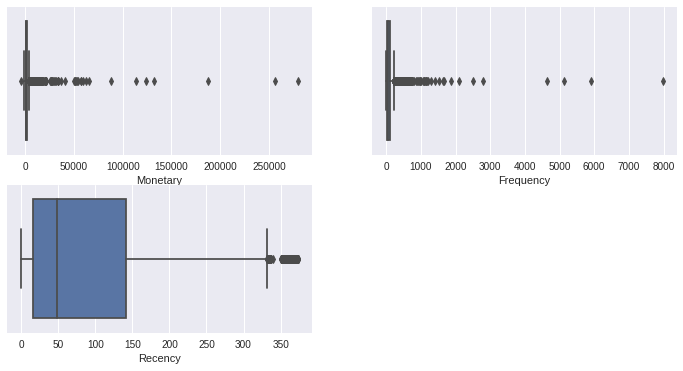

In [ ]:
num_features = cus_data.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=cus_data,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

In [ ]:
h_cap = 0.95
h_cap_val = cus_data['Monetary'].quantile(h_cap)
cus_data['Monetary'][cus_data['Monetary'] > h_cap_val] = h_cap_val
l_cap = 0.05
l_cap_val = cus_data['Monetary'].quantile(l_cap)
cus_data['Monetary'][cus_data['Monetary'] < l_cap_val] = l_cap_val

In [ ]:
cap = 0.95
cap_val = cus_data['Frequency'].quantile(cap)
cus_data['Frequency'][cus_data['Frequency'] > cap_val] = cap_val

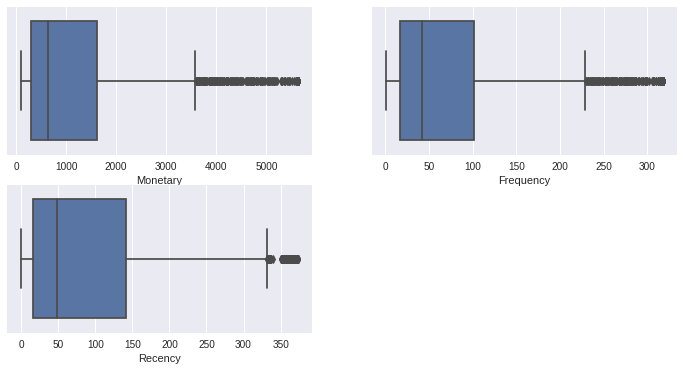

In [ ]:
num_features = cus_data.columns[1:]
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(12,6))

for n,i in enumerate(num_features):
    sns.boxplot(x=i, data=cus_data,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

Create pipelines for feature scaling and dimensionality reduction

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=2, random_state=42)),
        ]
    )
X = cus_data.drop('CustomerID',axis=1)
X_scaled = pd.DataFrame(preprocessor.fit_transform(X),columns=['PC_1','PC_2'])

STEP 4: Cluster using K-means clustering

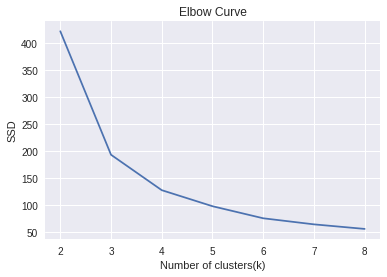

In [ ]:
#Finding Optimal value of K (Clusters)
# Elbow Method
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(range_n_clusters,ssd)
plt.xlabel('Number of clusters(k)')
plt.ylabel('SSD')
plt.title('Elbow Curve')
plt.show()


In [ ]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, round(silhouette_avg,2)))


For n_clusters=2, the silhouette score is 0.54
For n_clusters=3, the silhouette score is 0.55
For n_clusters=4, the silhouette score is 0.52
For n_clusters=5, the silhouette score is 0.48
For n_clusters=6, the silhouette score is 0.46
For n_clusters=7, the silhouette score is 0.44
For n_clusters=8, the silhouette score is 0.42


In [ ]:
# Run K-means using optimal K
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=1)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

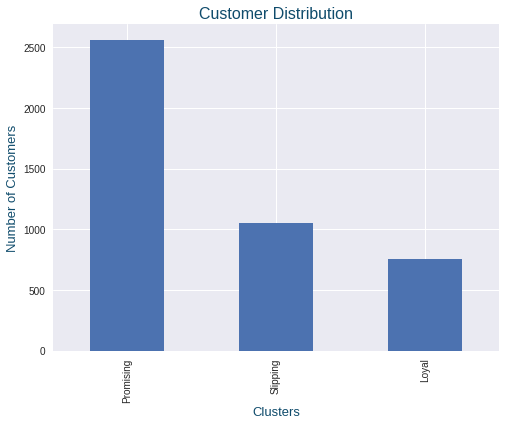

In [ ]:
# Adding cluster labels to master dataframe
X_scaled['cluster_id'] = kmeans.labels_
X['cluster_id'] = kmeans.labels_
# Number of customers per cluster

font_title = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 16,
        }


font_label = {
        'color':  '#104C6C',
        'weight': 'normal',
        'size': 13,
        }
plt.figure(figsize=(8,6))
ax = X_scaled['cluster_id'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Promising','Slipping','Loyal'])
ax.set_ylabel('Number of Customers',font_label)
ax.set_xlabel('Clusters',font_label)
ax.set_title("Customer Distribution",font_title)
plt.show()

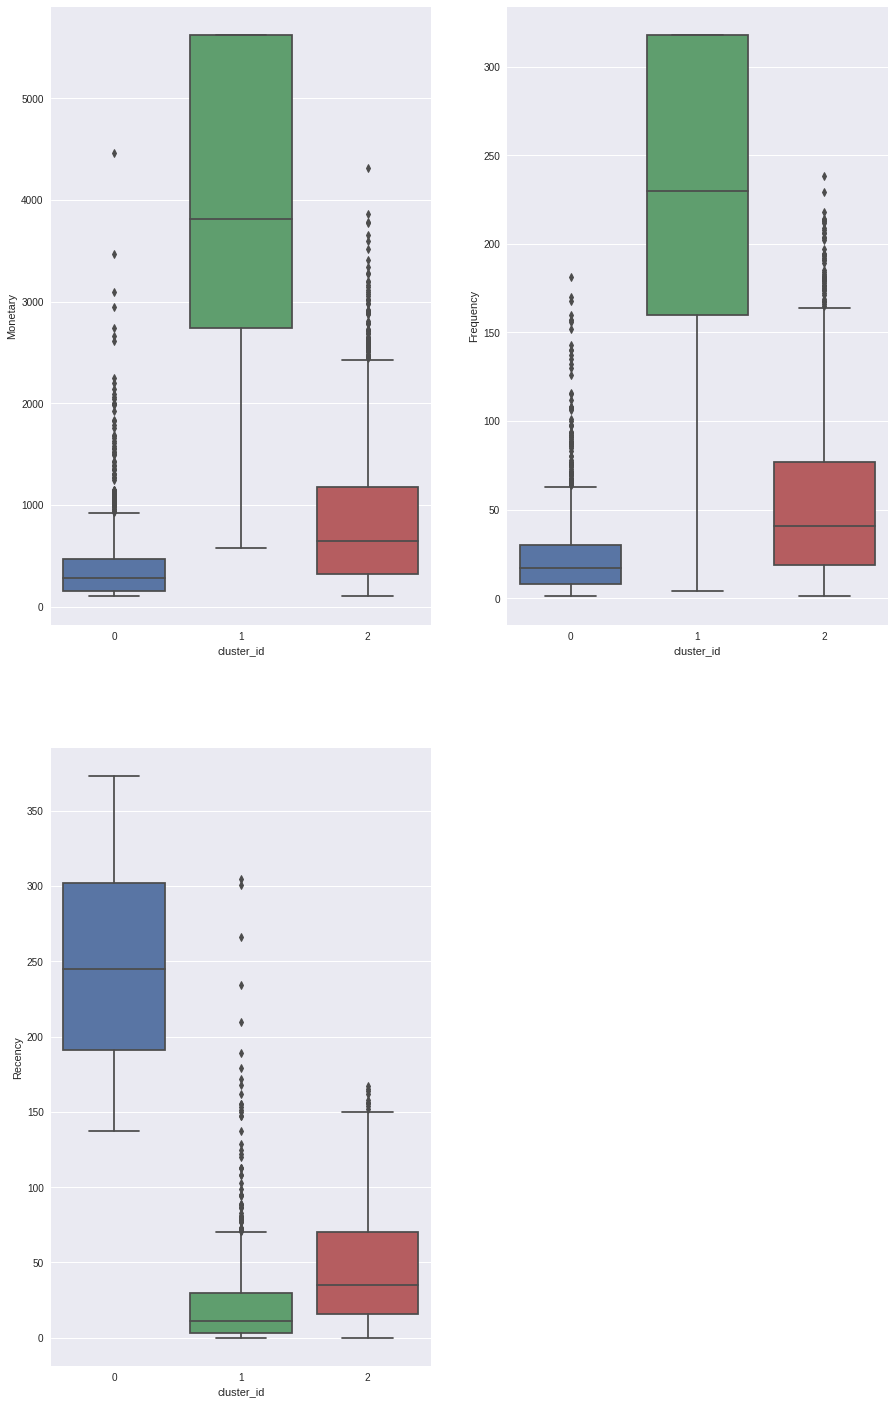

In [ ]:
# Clustering profiling using R-F-M
# Visualizing Numerical columns using Boxplots
cols = X.columns[0:-1].tolist()
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(15,25))

for n,i in enumerate(cols):
    sns.boxplot(x='cluster_id',y=cols[n], data=X,ax=ax[r,c])
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

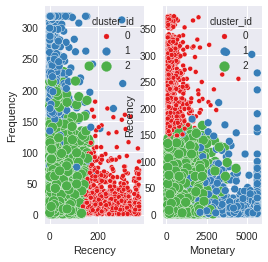

In [ ]:
plt.subplot(1,3,1)
sns.scatterplot(data=X,x="Recency",y="Frequency",hue="cluster_id",size="cluster_id",palette="Set1")
plt.subplot(1,3,2)
'''sns.scatterplot(data=X,x="Frequency",y="Monetary",hue="cluster_id",size="cluster_id",palette="Set1")
plt.subplot(1,3,3)'''
sns.scatterplot(data=X,x="Monetary",y="Recency",hue="cluster_id",size="cluster_id",palette="Set1")
plt.show()

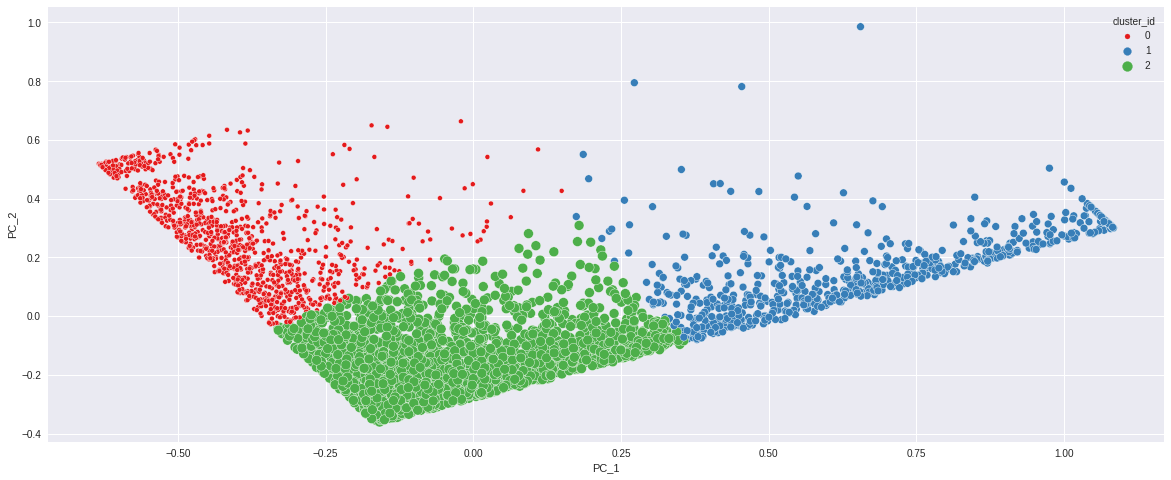

In [ ]:
# Vusializing clusters using Principle Components
fig = plt.figure(figsize=[20,8])

sns.scatterplot(data=X_scaled,x="PC_1",y="PC_2",hue="cluster_id",size="cluster_id",palette="Set1")
plt.show()